In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.optimize import curve_fit
import astropy.io.ascii as ascii
import time
from scipy.optimize import curve_fit
import emcee
import pickle
import os
from multiprocessing import Pool
from multiprocessing import cpu_count



os.environ["OMP_NUM_THREADS"] = "1"


#np.random.seed(666)

## Name of galaxy

In [ ]:
#galaxy='IC5332'
#galaxy='NGC0628'
#galaxy='NGC1087'
#galaxy='NGC1365' 
galaxy='NGC1512'
#galaxy='NGC1672'
#galaxy='NGC2835'
#galaxy='NGC3351'
#galaxy='NGC3627'
#galaxy='NGC5068'


## Function that calculates the 2-point cross-correlation function

In [ ]:
def w(x1, y1, x2, y2, xr, yr, rmin=0, rmax=5000, dr=25):

    ddarr=cdist(np.transpose(np.array([x1,y1])), np.transpose(np.array([x2,y2]))).ravel()  
    drarr=cdist(np.transpose(np.array([x1,y1])), np.transpose(np.array([xr,yr]))).ravel()

    # Count pairs in distance bins       
    N1=len(x1)
    N2=len(x2)
    Nr=len(xr)
    bins=np.arange(rmin+dr/2, rmax, dr) # centers of bins for output

    dd0, dd0bins = np.histogram(ddarr, bins=np.arange(rmin, rmax+dr, dr)) #here bins are bin edges
    dr0, dr0bins = np.histogram(drarr, bins=np.arange(rmin, rmax+dr, dr))
    
    # Normalize pair counts and compute cross-correlation function
    if (N1!=0)*(N2!=0)*(Nr!=0):
        dd=dd0/N1/N2
        dr=dr0/N1/Nr
        omega=dd/dr-1
    
        edd=np.sqrt(dd0)/N1/N2
        edr=np.sqrt(dr0)/N1/Nr

        eomega=np.sqrt((edd/dr)**2+(dd*edr/dr**2)**2)
    else:
        omega=np.repeat(np.nan, len(bins))
        eomega=np.repeat(np.nan, len(bins))
        
    return (bins, omega, eomega)


## Functions that draws N model GMCs and returns properties

In [ ]:
# This version just uses the observed GMC coordinates and assumes constant parameters for all clouds

def drawgmc_xy(x,y,rc=25,tc=30,ts=10,tfb=5,Ng=1,voff=10):

    ngmc=len(x) # number of GMCs
    
    xgmc=x # gmc x coordinates [pc]
    ygmc=y # gmc y coordinates [pc]
    
    rc=np.repeat(rc,ngmc) # gmc radius [pc]
    tc=np.repeat(tc,ngmc) # gmc lifetime [Myr]
    ts=np.repeat(ts,ngmc) # stellar SF tracer lifetime [Myr]
    tfb=np.repeat(tfb,ngmc) # stellar SF tracer emergence time [Myr]
    Ng=np.repeat(Ng,ngmc).astype(int) # number of massive SF episodes during gmc lifetime
    voff=np.repeat(voff,ngmc) # stellar SF tracer centorid to GMC centroid offset speed [km/s]

    tobs=np.random.uniform(0, tc-tfb+ts, ngmc) # random observation time for this cloud (between zero and tc+ts)
    fgmc=np.repeat(True, ngmc) # GMC visibility flag
    fgmc[tobs > tc]=False # visibility flag is False if GMC has faded

    return (xgmc, ygmc, rc, tc, ts, tfb, Ng, voff, tobs, fgmc)
    

In [ ]:
# This version samples GMC coordinates with a typical separation scale "l" within a dbox**2 kpc**2 box, and assumes constant parameters for all clouds
# Also returns random catalog coordinates over the same area and Frand*Ngmc points
def drawgmc_l(dbox=2000,l=200,rc=25,tc=30,ts=10,tfb=5,Ng=1,voff=10, frand=10):

    area=dbox**2
    ngmc=int(area/l**2) # number of GMCs
    
    xgmc=np.random.uniform(-0.5*dbox, 0.5*dbox, ngmc) # gmc x coordinates [pc]
    ygmc=np.random.uniform(-0.5*dbox, 0.5*dbox, ngmc) # gmc y coordinates [pc]

    xr=np.random.uniform(-0.5*dbox, 0.5*dbox, frand*ngmc) # gmc x coordinates [pc]
    yr=np.random.uniform(-0.5*dbox, 0.5*dbox, frand*ngmc) # gmc y coordinates [pc]

    rc=np.repeat(rc,ngmc) # gmc radius [pc]
    tc=np.repeat(tc,ngmc) # gmc lifetime [Myr]
    ts=np.repeat(ts,ngmc) # stellar SF tracer lifetime [Myr]
    tfb=np.repeat(tfb,ngmc) # stellar SF tracer emergence time [Myr]
    Ng=np.repeat(Ng,ngmc).astype(int) # number of massive SF episodes during gmc lifetime
    voff=np.repeat(voff,ngmc) # stellar SF tracer centorid to GMC centroid offset speed [km/s]
    tobs=np.random.uniform(0, tc-tfb+ts, ngmc) # random observation time for this cloud (between zero and tc+ts)
    fgmc=np.repeat(True, ngmc) # GMC visibility flag
    fgmc[tobs > tc]=False # visibility flag is False if GMC has faded

    #print("Generating GMC and random coordinates:", ngmc, frand*ngmc)
    return (xgmc, ygmc, rc, tc, ts, tfb, Ng, voff, tobs, fgmc, xr, yr)
    

## Function that draws N*Ng HII regions given an ensemble of GMCs

In [ ]:
def drawhii(xgmc, ygmc, rc, tc, ts, tfb, Ng, voff, tobs, fgmc):
    
    ngmc=len(xgmc) # number of GMCs
    nhii=np.sum(Ng.astype(int)) # number of HII regions
    voffaux=voff*3.2e-14*(1e6*365*24*3600) # velocity in pc/Myr

    xhii=np.zeros(nhii) # HII region initial coordinates
    yhii=np.zeros(nhii)
    t0=np.zeros(nhii) # HII region formation time
    fhii=np.repeat(False,nhii) # HII region visibility flag
    indgmc=np.zeros(nhii) # gmc list index

    k=0 # counter
    for i in range(ngmc):  # drawing HII regions for each GMC independently
        for j in range(Ng[i]):

            # initial position
            r0=rc[i]*np.sqrt(np.random.uniform(0,1)) # uniform across circular area
#            r0=rc[i]*np.random.uniform(0,1) # uniform in radius (i.e. as r**-2)
            theta0=np.random.uniform(0, 2*np.pi)
            x0=xgmc[i]+r0*np.cos(theta0)
            y0=ygmc[i]+r0*np.sin(theta0)

            #formation time (assuming stars form no later than tc-tfb)
            t0[k]=np.random.uniform(0, tc[i]-tfb[i])    
            
            #offset direction and final position at tobs
            phi=np.random.uniform(0, 2*np.pi)
            xhii[k]=x0+voffaux[i]*(tobs[i]-t0[k])*np.cos(phi)
            yhii[k]=y0+voffaux[i]*(tobs[i]-t0[k])*np.sin(phi)

            #visibility flag is True if cloud has already formed and emerged, and has not yet faded
            if (t0[k]+tfb[i]<tobs[i])*(tobs[i]<t0[k]+ts[i]):
                fhii[k]=True

                #print(t0[k], tfb[i], ts[i], tobs[i], t0[k]+tfb[i], t0[k]+ts[i], fhii[k])
            
            #GMC list index
            indgmc=i
            
            k=k+1
        
    
    return (xhii,yhii,fhii)
    
    
    

## Linear Model

In [ ]:
def lin(x, a, b):
    return a+b*x

## Power-law model 

In [ ]:
def pl(x, a, beta):
    return a*x**beta
    

## Read GMC and Random catalogs coordinates

In [ ]:
xygmc=ascii.read('./output/'+galaxy+'_xy_gmc.txt')
x1=xygmc['col0'].data
y1=xygmc['col1'].data

xyrand=ascii.read('./output/'+galaxy+'_xy_rand.txt')
xr=xyrand['col0'].data
yr=xyrand['col1'].data


## Read Observed Correlation Function

In [ ]:
obscorr=ascii.read('./output/'+galaxy+'_corr.txt')
r0obs=obscorr['col0'].data
w0obs=obscorr['col1'].data
ew0obs=obscorr['col2'].data

## Fit and remove large scale (few kpc) correlation using linear model

In [ ]:
rmin=500
rmax=3000
sel=(r0obs>=rmin)*(r0obs<=rmax)
popt, pcov = curve_fit(lin, r0obs[sel], w0obs[sel], sigma=ew0obs[sel])
print(popt)
w0small=w0obs-lin(r0obs, *popt)




#plot large scale fit

fig, ax = plt.subplots(figsize=(12, 8))
ax.errorbar(r0obs, w0obs, ew0obs, fmt="o", color='grey', capsize=5, alpha=0.5)
ax.plot(r0obs, w0obs, 'o', color='black', alpha=1.0)
ax.plot(r0obs[sel], w0obs[sel], 'o', color='red', alpha=0.5)
ax.plot(r0obs, lin(r0obs, *popt), color='red')
#ax.set_ylim(1e-3, 2e0)
ax.axhline(y=0, linestyle='--')
plt.xlabel('r [pc]', fontsize=20)
plt.ylabel(r'$\omega(r)$ [pc]', fontsize=20)
plt.title(galaxy, fontsize=30)
ax.tick_params(labelsize=20)
#ax.set_yscale('log')
#ax.set_xscale('log')
plt.savefig('./plots/'+galaxy+'_corr_linfit.png')
plt.show()

fig, ax = plt.subplots(figsize=(12, 8))
ax.errorbar(r0obs, w0small, ew0obs, fmt="o", color='grey', capsize=5, alpha=0.5)
ax.plot(r0obs, w0small, 'o', color='black', alpha=1.0)
ax.plot(r0obs[sel], w0small[sel], 'o', color='red', alpha=0.5)
ax.set_xlim(0, 1e3)
#ax.set_ylim(1e-3, 2e0)
ax.axhline(y=0, linestyle='--')
plt.xlabel('r [pc]', fontsize=20)
plt.ylabel(r'$\omega(r)-\omega_{lin}$ [pc]', fontsize=20)
plt.title(galaxy, fontsize=30)
ax.tick_params(labelsize=20)
#ax.set_yscale('log')
#ax.set_xscale('log')
plt.savefig('./plots/'+galaxy+'_corr_linfit.png')
plt.show()



## Function that Evaluates Cross Correlation Function for Model Parameters

In [ ]:
def eval_w(l0, rc0, tc0, ts0, tfb0, Ng0, voff0):
    
    t0=time.time()
    
    print("Evaluating Model:")
    print("l=", l0)
    print("rc=", rc0)
    print("tc=", tc0)
    print("ts=", ts0)
    print("tfb=", tfb0)
    print("Ng=", Ng0)
    print("voff=", voff0)

    Nsamples=500

    # Run w() one time to get bins
    xgmc, ygmc, rc, tc, ts, tfb, Ng, voff, tobs, fgmc, xr, yr = drawgmc_l(dbox=2000, l=l0, rc=rc0, tc=tc0, ts=ts0, tfb=tfb0, Ng=Ng0, voff=voff0, frand=10)
    xhii, yhii, fhii = drawhii(xgmc, ygmc, rc, tc, ts, tfb, Ng, voff, tobs, fgmc)
    r0, w0, ew0 = w(xgmc[fgmc], ygmc[fgmc], xhii[fhii], yhii[fhii], xr, yr, rmax=1000)   
    w0arr=np.zeros((len(w0),Nsamples))
    ew0arr=np.zeros((len(ew0),Nsamples))
    
   
    # Run w() Nsample times and average
    for i in range(Nsamples):
    
        xgmc, ygmc, rc, tc, ts, tfb, Ng, voff, tobs, fgmc, xr, yr = drawgmc_l(dbox=2000, l=l0, rc=rc0, tc=tc0, ts=ts0, tfb=tfb0, Ng=Ng0, voff=voff0, frand=10)
        xhii, yhii, fhii = drawhii(xgmc, ygmc, rc, tc, ts, tfb, Ng, voff, tobs, fgmc)
        r0, w0arr[:,i], ew0arr[:,i] = w(xgmc[fgmc], ygmc[fgmc], xhii[fhii], yhii[fhii], xr, yr, rmax=1000)
        
    w0arr[~np.isfinite(w0arr)]=np.nan
    ew0arr[~np.isfinite(ew0arr)]=np.nan    
    w0=np.nanmean(w0arr, axis=1)
    ew0=np.nanmean(ew0arr, axis=1)/np.sqrt(Nsamples)
    
    
    print("Model Evaluation Run Time [s] =", time.time()-t0)

    
  
    fig, ax = plt.subplots(figsize=(12, 8))
    #for i in range(Nsamples):
    #    ax.plot(r0, w0arr[:,i], 'o', color='red', alpha=0.5)
    #for i in range(Ntest):
    #    ax.plot(r0, w0test[:,i], 'o', color='green', alpha=0.5)
    ax.plot(r0, w0, 'o', color='green', alpha=1.0)    
    ax.errorbar(r0obs, w0small, ew0obs, fmt="o", color='black', capsize=5, alpha=0.5)
    ax.plot(r0obs, w0small, '-o', color='black', alpha=0.5)
    ax.set_xlim(0, 1000)
    ax.axhline(y=0, linestyle='--')
    ax.set_xlabel('r [pc]', fontsize=20)
    ax.set_ylabel(r'$\omega(r)$ [pc]', fontsize=20)
    ax.set_title(galaxy, fontsize=30)
    ax.tick_params(labelsize=20)
    #ax.set_yscale('log')
    #ax.set_ylim(-0.2, 4)
    plt.savefig('./plots/'+galaxy+'_corr_model.png')
    plt.show()
    
    fig, ax = plt.subplots(figsize=(12, 12))
    #ax.plot(xgmc, ygmc, '.', color='blue', alpha=0.4)
    ax.plot(xgmc[fgmc], ygmc[fgmc], 'o', color='blue', label='GMC')
    #ax.plot(xhii, yhii, '.', color='red', alpha=0.4)
    ax.plot(xhii[fhii], yhii[fhii], 'o', color='red', label='HII')
    #ax.set_xlim(-1000, 1000)
    #ax.set_ylim(-1000, 1000)
    ax.set_xlabel('X [pc]', fontsize=20)
    ax.set_ylabel('Y [pc]', fontsize=20)
    ax.set_title(galaxy, fontsize=30)
    ax.tick_params(labelsize=20)
    ax.legend(fontsize=20)
    plt.savefig('./plots/'+galaxy+'_xy_model.png')
    plt.show()


    
    return (w0, ew0)


# Define Priors and Likelihood Functions

In [ ]:
# Trim observed corr function to <=1kpc
selr=(r0obs<=1000)


def log_prior(p):
    l1, rc1, tc1, ts1, tfb1, Ng1, voff1 = p
    if 10<l1<300 and 5<rc1<100 and 1<tc1<500 and 1<ts1<20 and 1<tfb1<20 and 1<Ng1<10 and 0<voff1<30:
        return 0.0
    else:
        return -np.inf

def log_prob(p):
    lprior=log_prior(p)
    if np.isfinite(lprior):
        w0, ew0 = eval_w(l0=p[0], rc0=p[1], tc0=p[2], ts0=p[3], tfb0=p[4], Ng0=p[5], voff0=p[6])
        res=w0-w0small[selr]
        sig=ew0obs[selr]
        prob=1/(2*np.pi*sig**2)*np.exp(-0.5*(res/sig)**2)
        logp=lprior+np.sum(np.log(prob))
        if not np.isfinite(logp):
#        print("fail2")
            return -np.inf
        return logp
    else:
        return -np.inf

        



# Set up MCMC

In [ ]:
ndim=7
nwalkers=16

p0 = np.zeros((nwalkers, ndim))
p0[:,0]=np.random.uniform(50, 200, nwalkers)
p0[:,1]=np.random.uniform(20, 100, nwalkers)
p0[:,2]=np.random.uniform(1, 500, nwalkers)
p0[:,3]=np.random.uniform(5, 15, nwalkers)
p0[:,4]=np.random.uniform(1, 10, nwalkers)
p0[:,5]=np.random.uniform(1, 10, nwalkers)
p0[:,6]=np.random.uniform(0, 30, nwalkers)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob)

# Run MCMC Chain

Evaluating Model:
l= 143.94300453446445
rc= 83.90755528205199
tc= 151.43365393161292
ts= 7.946621223936038
tfb= 8.601675504680733
Ng= 2.996109691492376
voff= 26.58656077684834


/Users/gblancm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
/Users/gblancm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice


Model Evaluation Run Time [s] = 16.991247177124023


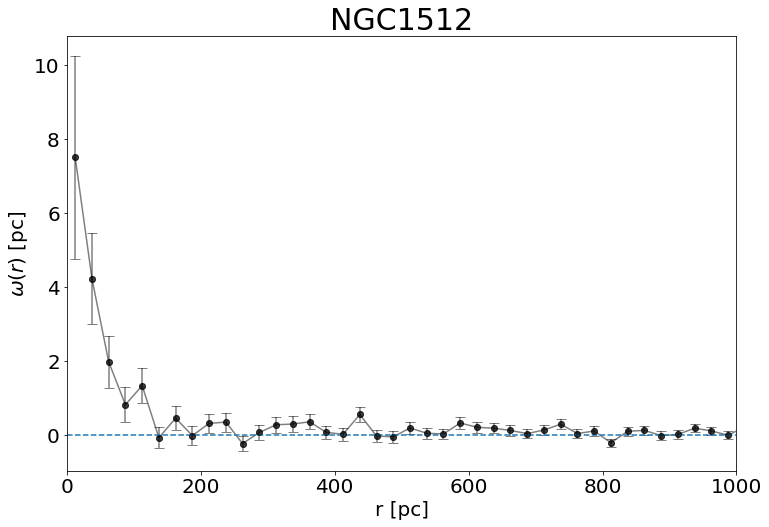

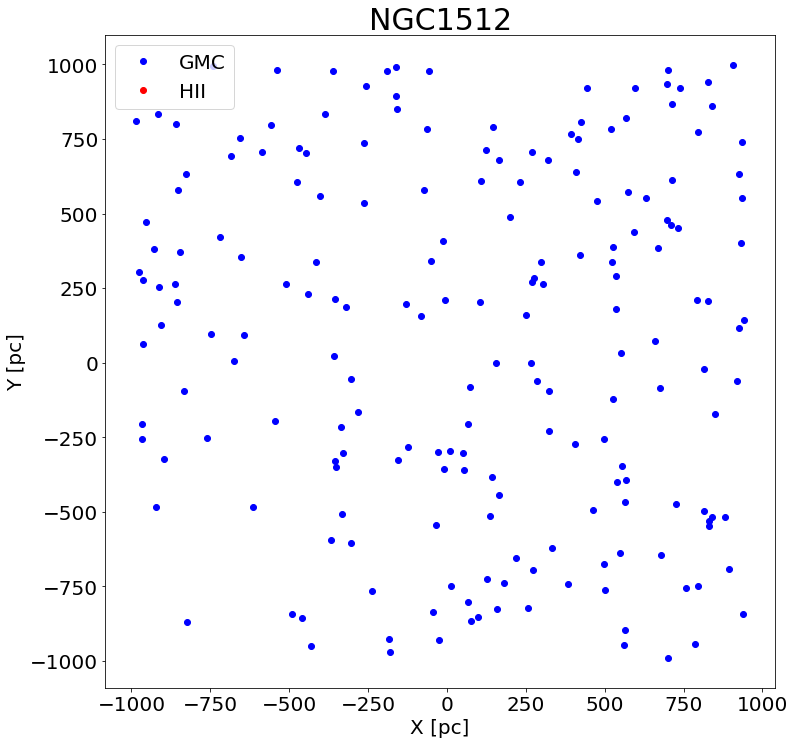

Evaluating Model:
l= 125.92111795684545
rc= 58.36672582593215
tc= 36.98368878823704
ts= 11.560593820136377
tfb= 8.571894198614677
Ng= 4.876432079676071
voff= 10.918021727871741
emcee: Exception while calling your likelihood function:
  params: [125.92111796  58.36672583  36.98368879  11.56059382   8.5718942
   4.87643208  10.91802173]
  args: []
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/Users/gblancm/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-27-a84290505f5f>", line 14, in log_prob
    w0, ew0 = eval_w(l0=p[0], rc0=p[1], tc0=p[2], ts0=p[3], tfb0=p[4], Ng0=p[5], voff0=p[6])
  File "<ipython-input-26-4ee15acde4c3>", line 29, in eval_w
    r0, w0arr[:,i], ew0arr[:,i] = w(xgmc[fgmc], ygmc[fgmc], xhii[fhii], yhii[fhii], xr, yr, rmax=1000)
KeyboardInterrupt


KeyboardInterrupt: 

In [29]:
sampler.reset()
Nmc=500
state = sampler.run_mcmc(p0,Nmc)


## Test Paralell MCMC

Evaluating Model:
Evaluating Model:
Evaluating Model:
Evaluating Model:
l= 143.94300453446445
l= 115.76548074443872
l= 125.92111795684545
rc= 59.55029837045145
l= 124.7828093039325
rc= 83.90755528205199
tc= 496.3327267785653
rc= 58.36672582593215
tc= 151.43365393161292
rc= 25.834330592106838
ts= 8.49093997476554
tc= 36.98368878823704
tc= 305.65037783791684
ts= 7.946621223936038
tfb= 9.314662640651287
ts= 11.560593820136377
tfb= 8.601675504680733
ts= 8.084204559565649
tfb= 8.571894198614677
Ng= 8.529406321257751
Ng= 2.996109691492376
tfb= 9.026419361096554
Ng= 4.876432079676071
voff= 4.1095545005372935
Ng= 7.270255725611109
voff= 26.58656077684834
voff= 10.918021727871741
voff= 1.7070473471189607


/Users/gblancm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
/Users/gblancm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice


Model Evaluation Run Time [s] = 24.488460779190063


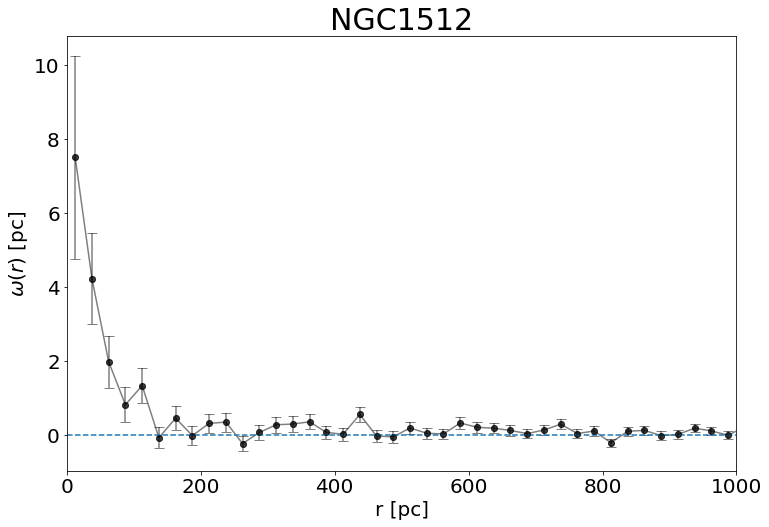

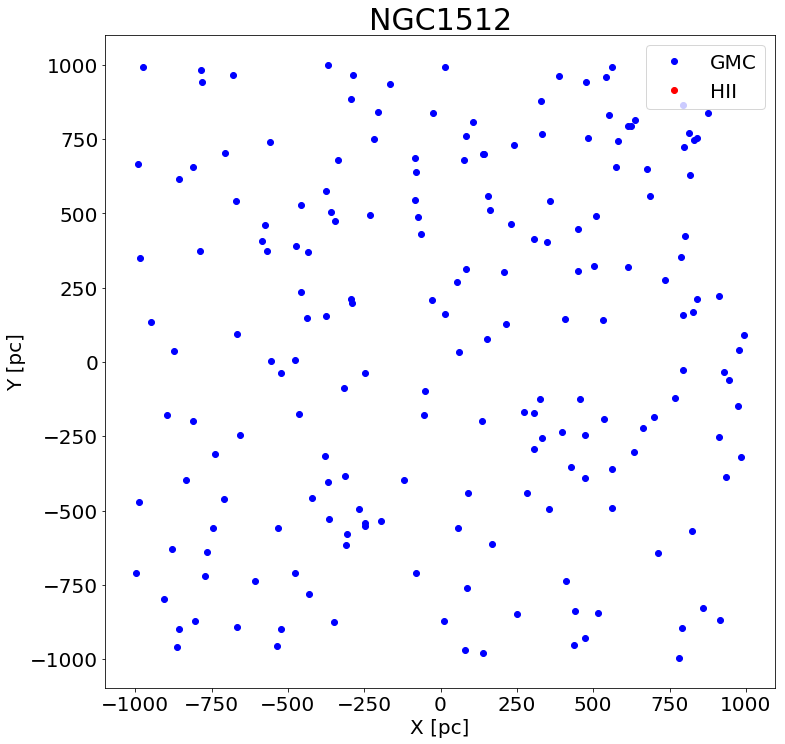

Evaluating Model:
l= 185.1863267581908
rc= 72.41198592431638
tc= 211.1109263904728
ts= 14.115048832795217
tfb= 8.412426833235958
Ng= 8.825558779095351
voff= 6.438691495283431
Model Evaluation Run Time [s] = 19.54945993423462
Model Evaluation Run Time [s] = 45.063441038131714


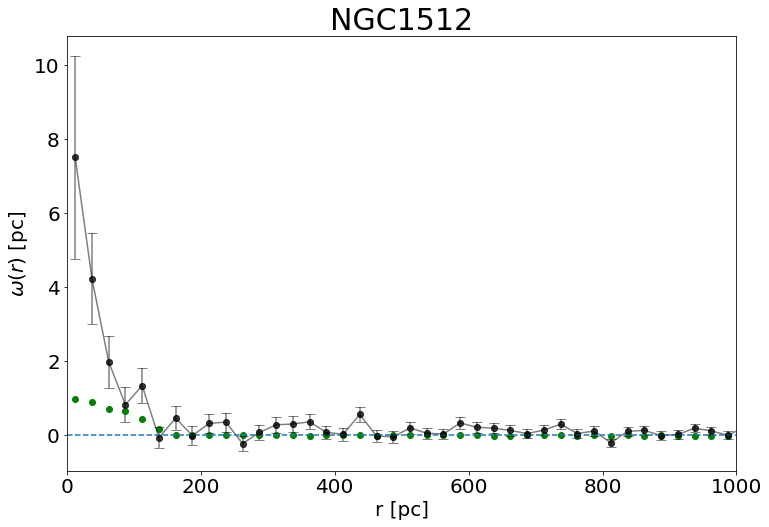

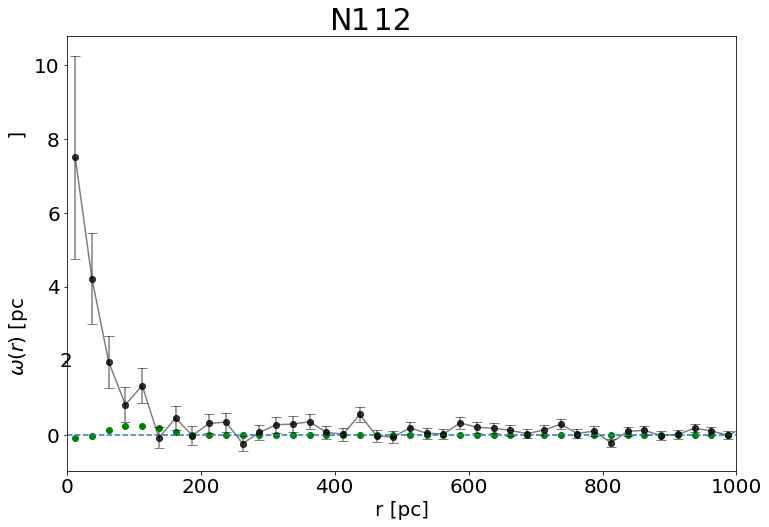

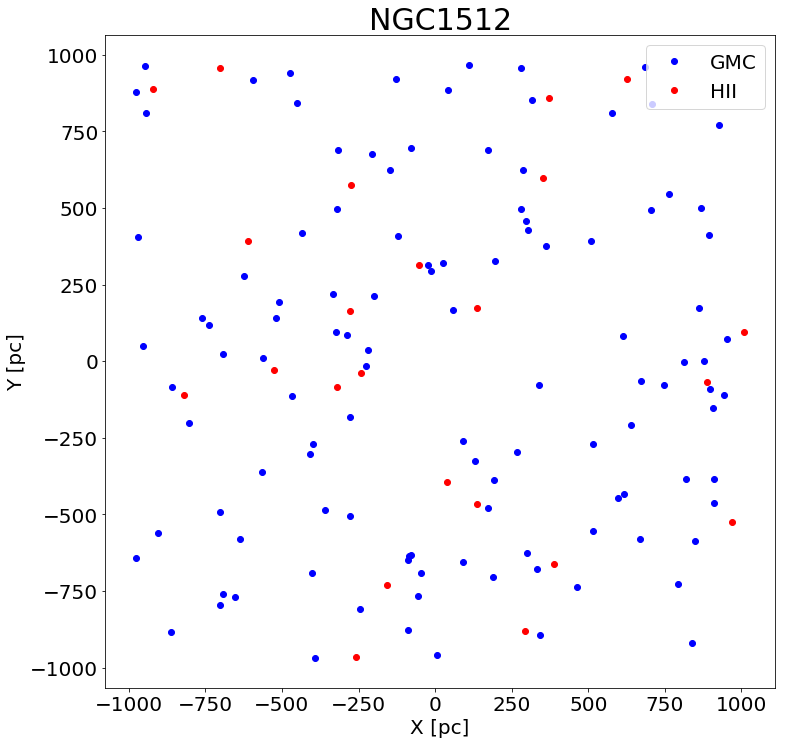

Evaluating Model:
l= 119.81254827646741
rc= 59.28208480283661
tc= 80.49379146003575
ts= 12.108400538569418
tfb= 9.220249147032773
Ng= 1.372654871428434
voff= 13.050324543094021


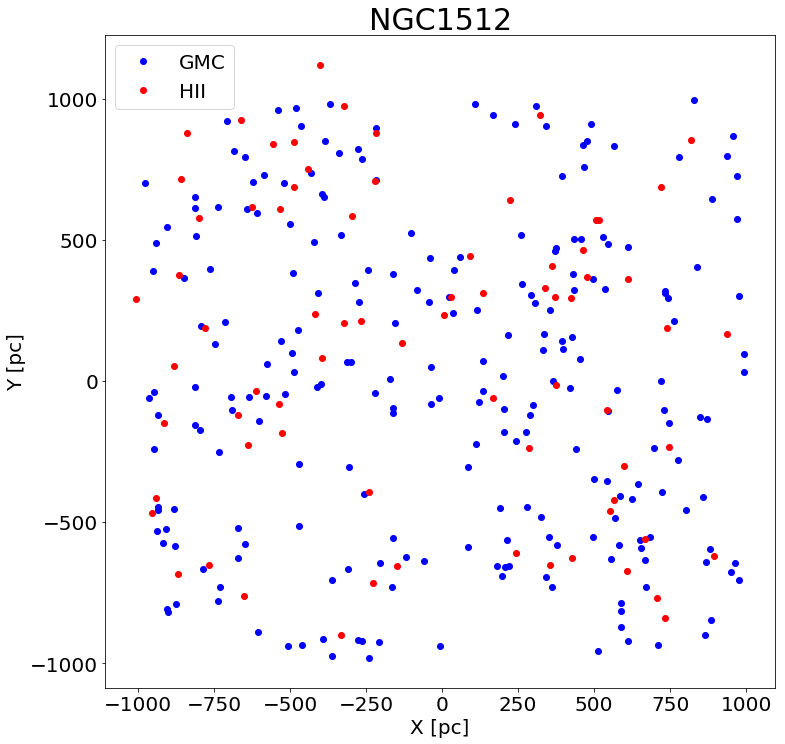

Evaluating Model:
l= 165.6035481262926
rc= 76.75004485771231
tc= 243.78778693442737
ts= 10.161974860854649
tfb= 2.65177969935986
Ng= 6.6988824052268665
voff= 6.4838035168449295


/Users/gblancm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
/Users/gblancm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice


Model Evaluation Run Time [s] = 59.187851905822754


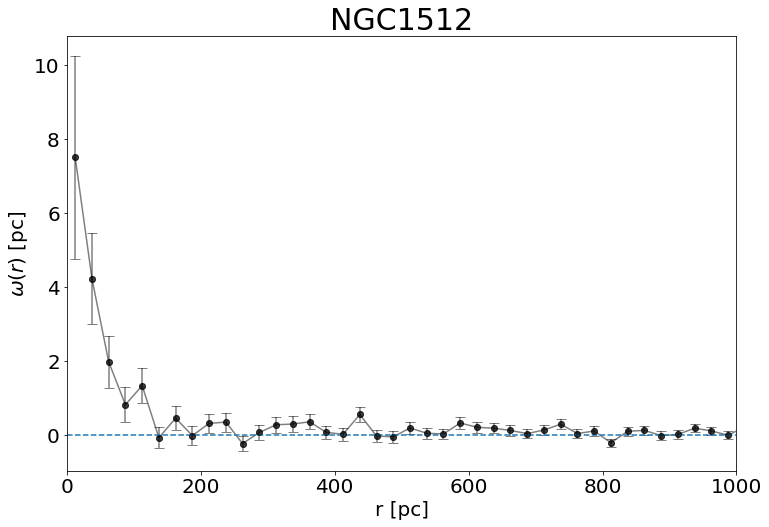

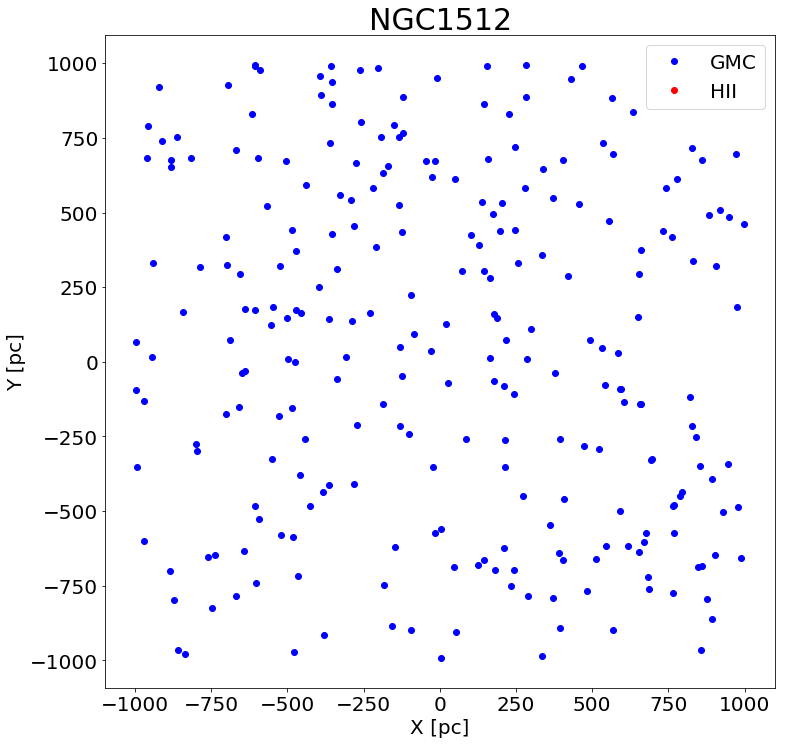

Evaluating Model:
l= 53.991721330271396
rc= 81.65538538841798
tc= 370.39935037214053
ts= 14.79091282749905
tfb= 2.632794076738373
Ng= 8.630514673062105
voff= 18.23614931333955
Model Evaluation Run Time [s] = 26.453155994415283


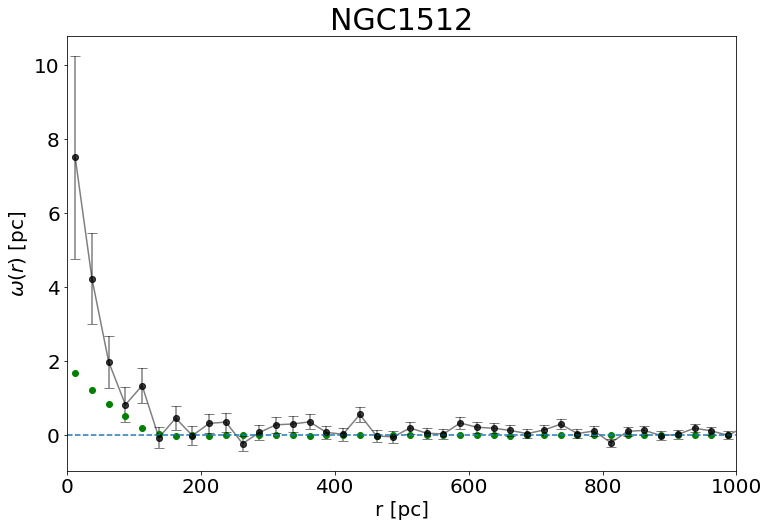

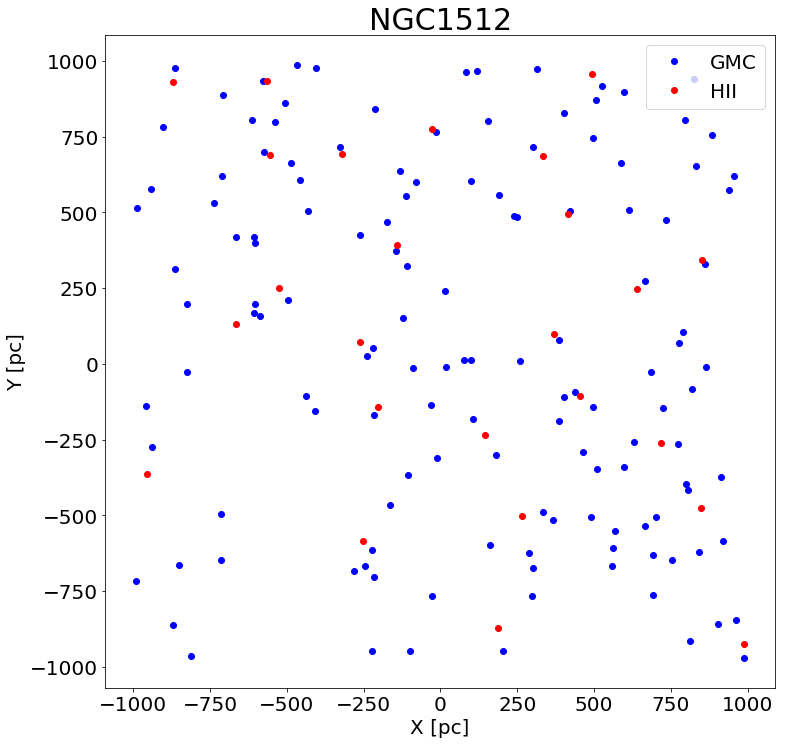

Evaluating Model:
l= 115.2554281981666
rc= 53.876971447605875
tc= 80.55325001699352
ts= 10.992299247301636
tfb= 6.740929864640192
Ng= 6.849645025589421
voff= 2.4605148475409155


/Users/gblancm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
/Users/gblancm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice


Model Evaluation Run Time [s] = 80.0308473110199


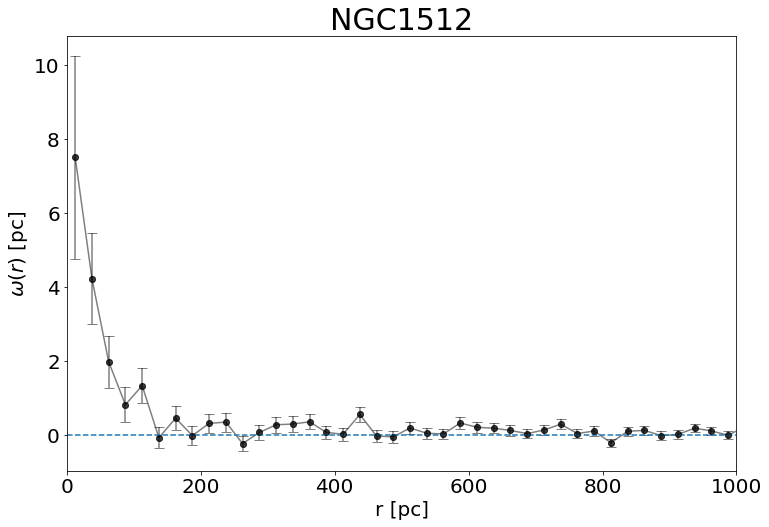

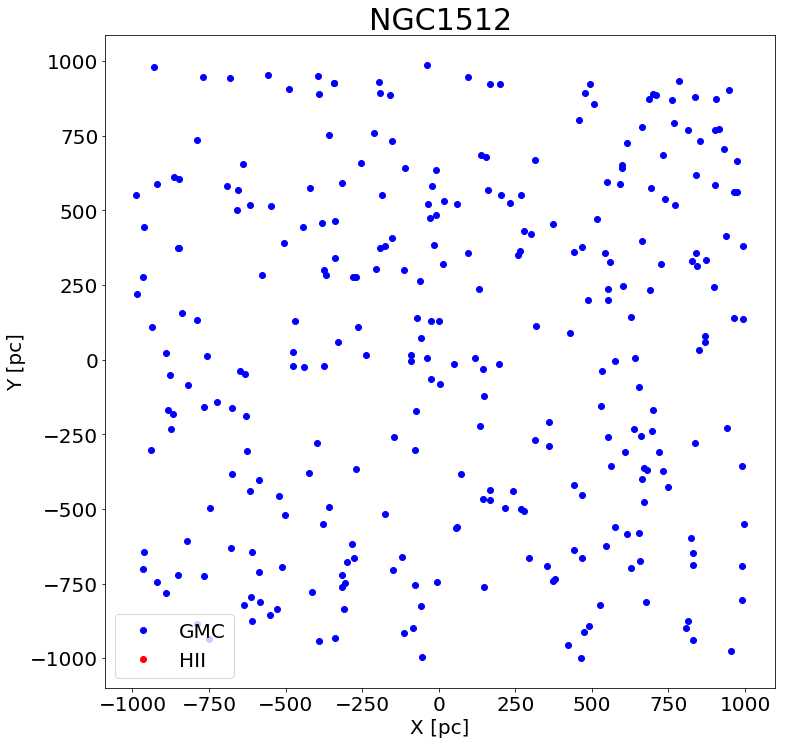

Evaluating Model:
l= 138.59613607487648
rc= 63.59364957912504
tc= 285.1257791186133
ts= 7.786741827164106
tfb= 9.848566814067393
Ng= 8.915297512053467
voff= 3.4595162840304896
Model Evaluation Run Time [s] = 45.90003681182861


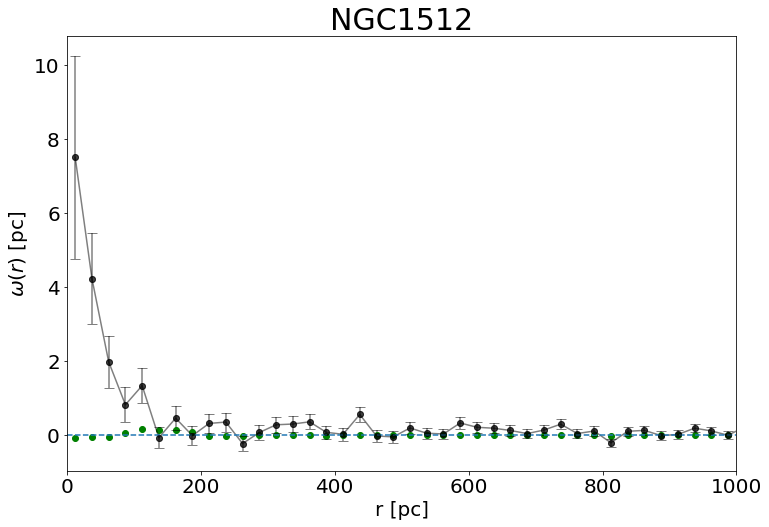

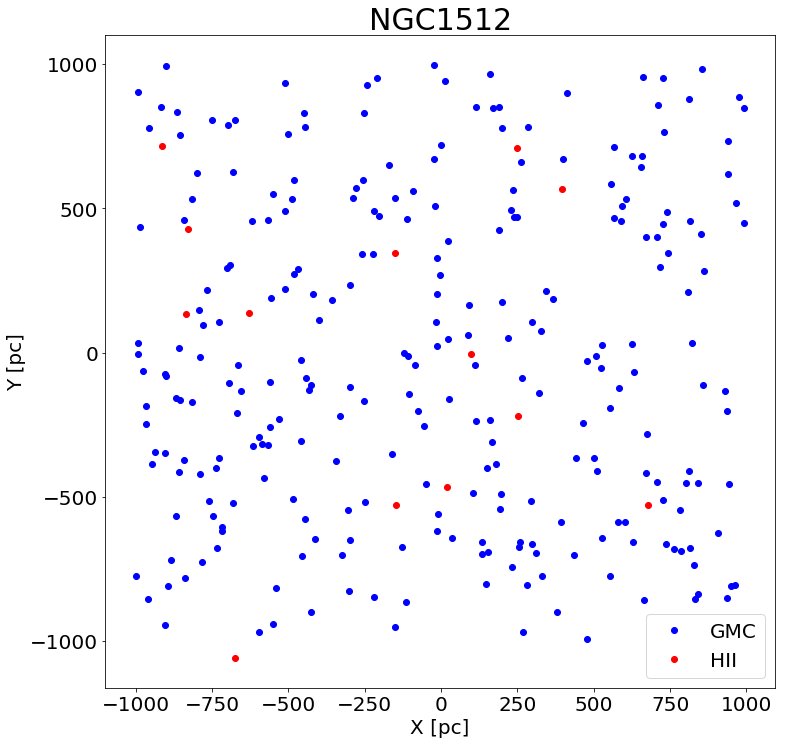

Evaluating Model:
l= 75.14961475813948
rc= 21.389272095327154
tc= 193.98361190644385
ts= 13.314500620758828
tfb= 5.03345601163332
Ng= 6.707173492056073
voff= 28.056893664990547
Model Evaluation Run Time [s] = 43.90327596664429


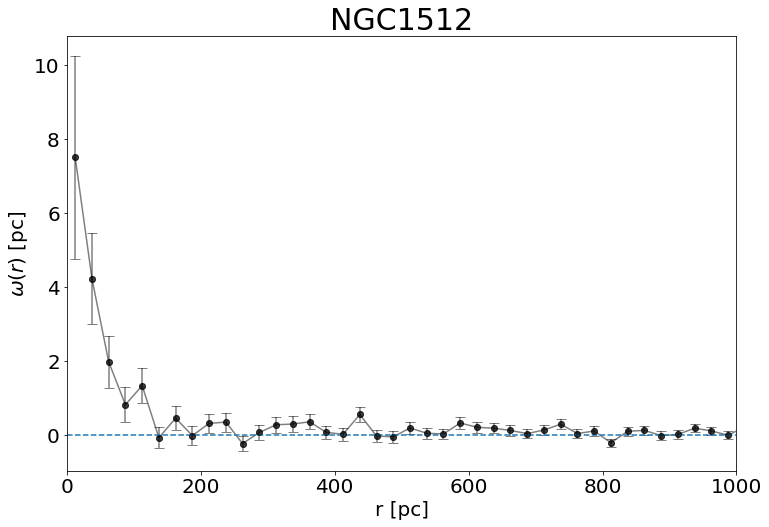

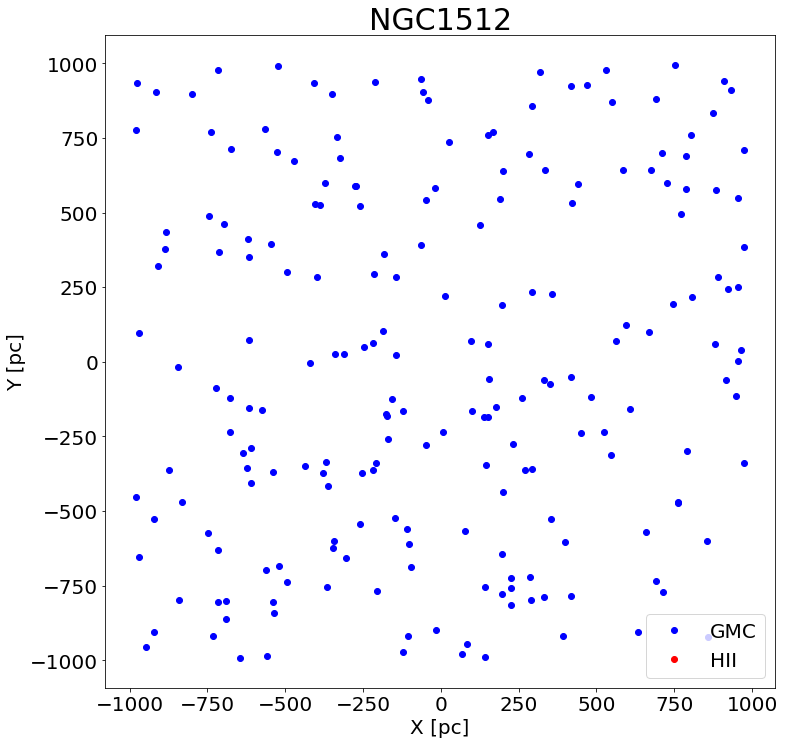

Evaluating Model:
l= 115.2789670758813
rc= 58.507052245829634
tc= 182.31732582452034
ts= 9.218267185264784
tfb= 7.657947282110034
Ng= 3.9766127088571985
voff= 24.06063575850686
Model Evaluation Run Time [s] = 76.27722716331482


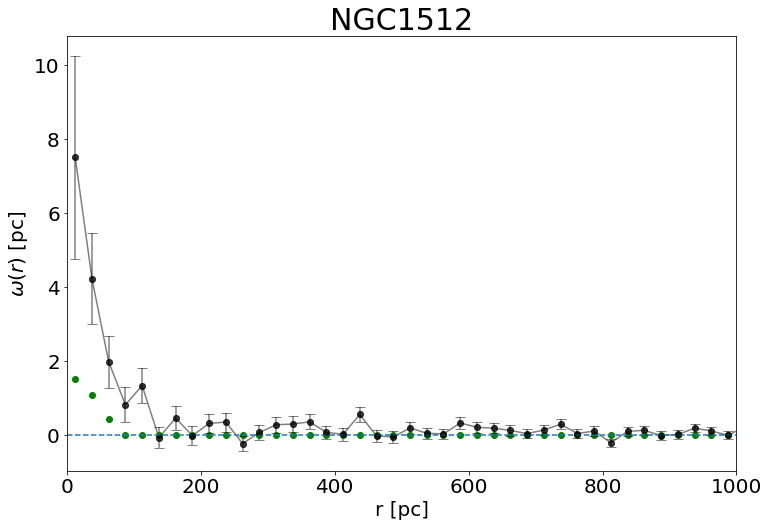

emcee: Exception while calling your likelihood function:
  params: [115.27896708  58.50705225 182.31732582   9.21826719   7.65794728
   3.97661271  24.06063576]
  args: []
emcee: Exception while calling your likelihood function:
  kwargs: {}
  params: [ 53.99172133  81.65538539 370.39935037  14.79091283   2.63279408
   8.63051467  18.23614931]  exception:

  args: []


Traceback (most recent call last):


  kwargs: {}


  File "/Users/gblancm/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)


  exception:


KeyboardInterrupt: 

In [33]:
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, pool=pool)
    sampler.reset()
    state = sampler.run_mcmc(p0,Nmc)

# Pickle and Unpickle MCMC Chain

In [ ]:
with open('mcmc.pkl', 'wb') as f:
    pickle.dump(sampler, f, pickle.HIGHEST_PROTOCOL)
    
with open('mcmc.pkl', 'rb') as f:
    sampler = pickle.load(f)
    

In [ ]:
logp=sampler.lnprobability
print(np.shape(logp))
maxlogp=np.max(logp)
selbest=np.where(logp == maxlogp)
bestwalk=selbest[0][0]
bestsamp=selbest[1][0]
pbest=samples[bestwalk, bestsamp, :]
print(pbest)




In [ ]:
samples = sampler.chain
print(np.shape(samples))
print(np.median(samples[:,-1,:],axis=0))



fig, axes = plt.subplots(8, figsize=(20, 50), sharex=True)
labels = ["l", "rc", "tc", "ts", "tfb", "Ng", "voff"]
for i in range(ndim):
    ax = axes[i]
    for j in range(nwalkers):
        ax.plot(samples[j, :, i], "-", alpha=0.7)
#    ax.set_xlim(0, Nmc)
#    ax.set_ylim(-20,100)
    ax.set_ylabel(labels[i], fontsize=20)
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.set_xlabel("step number");
    
ax=axes[7]
for j in range(nwalkers):
    ax.plot(logp[j,:])
    ax.set_ylabel("logP")
    ax.set_ylim(100,150)


In [ ]:
import corner

goodsamples=samples[:,200:-1,:]
flat_goodsamples=goodsamples.reshape((np.shape(goodsamples)[0]*np.shape(goodsamples)[1],np.shape(goodsamples)[2]))
fig = corner.corner(flat_goodsamples, labels=labels, range=[(100,300), (5,100), (1,500), (1,10), (1,30), (1, 10), (0,30)]);


# Evaluate Best-Fit Model 

In [ ]:
pbest=[128.25868127,  76.18761797, 334.78822039,   9.90501884,   1.66665144,  7.16193951,   9.986711]
w0, ew0 = eval_w(l0=pbest[0], rc0=pbest[1], tc0=pbest[2], ts0=pbest[3], tfb0=pbest[4], Ng0=pbest[5], voff0=pbest[6])




In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
#for i in range(Nsamples):
#    ax.plot(r0, w0arr[:,i], 'o', color='red', alpha=0.5)
#for i in range(Ntest):
#    ax.plot(r0, w0test[:,i], 'o', color='green', alpha=0.5)
ax.plot(r0, w0, 'o', color='green', alpha=1.0)    
ax.errorbar(r0obs, w0small, ew0obs, fmt="o", color='black', capsize=5, alpha=0.5)
ax.plot(r0obs, w0small, '-o', color='black', alpha=0.5)
ax.set_xlim(0, 1000)
ax.axhline(y=0, linestyle='--')
ax.set_xlabel('r [pc]', fontsize=20)
ax.set_ylabel(r'$\omega(r)$ [pc]', fontsize=20)
ax.set_title(galaxy, fontsize=30)
ax.tick_params(labelsize=20)
#ax.set_yscale('log')
#ax.set_ylim(-0.2, 4)
plt.savefig('./plots/'+galaxy+'_corr_model.png')
plt.show()
    

In [ ]:
 
fig, ax = plt.subplots(figsize=(12, 12))
#ax.plot(xgmc, ygmc, '.', color='blue', alpha=0.4)
ax.plot(xgmc[fgmc], ygmc[fgmc], 'o', color='blue', label='GMC')
#ax.plot(xhii, yhii, '.', color='red', alpha=0.4)
ax.plot(xhii[fhii], yhii[fhii], 'o', color='red', label='HII')
#ax.set_xlim(-1000, 1000)
#ax.set_ylim(-1000, 1000)
ax.set_xlabel('X [pc]', fontsize=20)
ax.set_ylabel('Y [pc]', fontsize=20)
ax.set_title(galaxy, fontsize=30)
ax.tick_params(labelsize=20)
ax.legend(fontsize=20)
plt.savefig('./plots/'+galaxy+'_xy_model.png')
#plt.show()




In [ ]:
# Convert Notebook to Python Script
!jupyter nbconvert --to script gmc_hii_corr_model.ipynb


In [36]:
print(cpu_count())

4
